# Prepare Data

## Setup

Create a conda environment to do the CLIP embedding.
This won't be used after the vectors are generated.

To install the conda environment, run:
```shell
source $(conda info | grep -i "base environment" | cut -d ":" -f 2 | cut -d " " -f 2)/bin/activate
conda create --yes -n clip
conda activate clip
conda install --yes -c pytorch torchvision cudatoolkit ipykernel pandas pyarrow seaborn
pip install git+https://github.com/openai/CLIP.git
pip install ood_metrics
```

Install instructions from https://github.com/openai/CLIP/tree/main#usage

To add a conda environment as a kernel for jupyter, run:
```shell
conda activate clip
conda install ipykernel
python -m ipykernel install --user --name clip --display-name clip
```
Then in the top right corner of the notebook, switch the kernel to `clip`.

To list the installed kernels (requires `jupyter` be installed), run:
```shell
jupyter kernelspec list
```
To remove an installed kernel, run:
```shell
jupyter kernelspec uninstall clip
```

In [93]:
import gzip
import tarfile
import urllib.request
from itertools import islice
from pathlib import Path

import clip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import torch
from PIL import Image
from tqdm import tqdm

In [94]:
def batched(iterable, n):
    # batched('ABCDEFG', 3) → ABC DEF G
    if n < 1:
        raise ValueError("n must be at least one")
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

In [95]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [96]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [97]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [98]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:",
      f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [99]:
data_path = Path("data/")

## MNIST

The [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) contains 70,000 images of handwritten digits divided across 10 classes. Each class contains roughly 7,000 images. It is further divided by writer into 60,000 train and 10,000 test examples.

```
@misc{mnist,
  title={The MNIST database of handwritten digits},
  author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
  howpublished={\url{http://yann.lecun.com/exdb/mnist/}},
  year={1998},
}
```

### Download

In [100]:
filenames = (
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
)

In [101]:
# http://yann.lecun.com/exdb/mnist/
# has blacklisted the default urllib user agent.
# https://github.com/pytorch/vision/issues/3497#issuecomment-789996883
# Use the PyTorch mirror instead.
for filename in filenames:
    url = f"https://storage.googleapis.com/cvdf-datasets/mnist/{filename}"
    _ = urllib.request.urlretrieve(url, str(data_path / "mnist" / filename))

In [102]:
image_size = 28
images = dict()
labels = dict()
n_examples = {"train": 60_000, "test": 10_000}
for filename in filenames:
    if filename.startswith("train"):
        split = "train"
    elif filename.startswith("t10k"):
        # Are test examples.
        split = "test"
    with gzip.open(data_path / "mnist" / filename, "rb") as file:
        if "images" in filename:
            # Skip header.
            file.read(16)
            buffer = file.read(image_size * image_size * n_examples[split])
            images[split] = np.frombuffer(
                buffer,
                dtype=np.uint8,
            ).reshape(n_examples[split], image_size, image_size)
        elif "labels" in filename:
            # Skip header.
            file.read(8)
            buffer = file.read(n_examples[split])
            labels[split] = np.frombuffer(buffer, dtype=np.uint8)

In [103]:
df_test = pd.DataFrame({
    "class": labels["test"],
    "split": "test",
    "image": [image for image in images["test"]],
})
df_train = pd.DataFrame({
    "class": labels["train"],
    "split": "train",
    "image": [image for image in images["train"]],
})

In [104]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [105]:
df["image"] = df["image"].apply(lambda x: np.array(x, dtype=np.uint8))

In [106]:
df.groupby("class").size()

class
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
dtype: int64

### Embed

In [107]:
clip_vectors = []
n = 64
total = len(df["image"]) // n + (len(df["image"]) % n > 0)
for batch in tqdm(batched(df["image"], n), total=total):
    image_input = [preprocess(Image.fromarray(x, mode="L")) for x in batch]
    image_features = model.encode_image(
        torch.stack(image_input).to(device)).detach().numpy()
    clip_vectors.append(image_features)
clip_vectors = np.vstack(clip_vectors)

100%|██████████| 1094/1094 [07:02<00:00,  2.59it/s]


In [108]:
df["clip"] = clip_vectors.tolist()

In [109]:
df["clip_norm"] = (
    clip_vectors /
    np.linalg.norm(clip_vectors, axis=1, keepdims=True)).tolist()

In [110]:
df["image"] = df["image"].apply(lambda x: x.reshape((28, 28)).tolist())

In [111]:
np.savez_compressed(str(data_path / "mnist" / "mnist.npz"), clip_vectors)

In [112]:
df.to_parquet(data_path / "mnist" / "mnist.parquet")

In [113]:
clip_vectors

array([[-0.00821754, -0.2220476 , -0.4927631 , ...,  1.2824292 ,
         0.01600289, -0.2064659 ],
       [-0.03195322, -0.19248381, -0.33667937, ...,  1.2215558 ,
        -0.05405898, -0.19317284],
       [-0.03764144, -0.14464767, -0.39928865, ...,  1.267581  ,
        -0.18459448,  0.11756142],
       ...,
       [-0.17190191, -0.1267277 , -0.5101864 , ...,  1.3828164 ,
         0.00603148, -0.0535227 ],
       [-0.06797408, -0.36638683, -0.4276412 , ...,  1.232866  ,
        -0.07813132, -0.13707848],
       [ 0.03299807, -0.31332576, -0.40741503, ...,  1.3743666 ,
         0.089656  , -0.07972805]], dtype=float32)

###

PyTorch expects tensors to be in channels first format, unlike TensorFlow which uses channels last. https://pytorch.org/blog/tensor-memory-format-matters/

`preprocess` takes care of grayscale to RGB conversion, channel first formatting, and ensuring the image size is larger than the kernel size of (32 x 32).

In [114]:
def grayscale_to_rgb(image: np.ndarray):
    """Converts a grayscale image to RGB.

    Repeats the image over all 3 channels like
    tensorflow.image.grayscale_to_rgb .
    The input images' last dimension must be size 1.
    """
    return np.repeat(image, 3, 0)

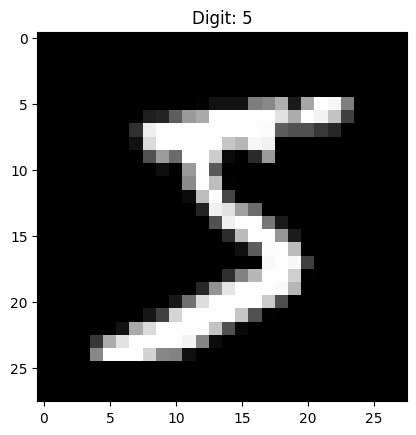

In [115]:
plt.figure()
plt.imshow(df.loc[0, "image"], cmap="gray")
plt.title(f'Digit: {df.loc[0, "class"]}')
plt.show()

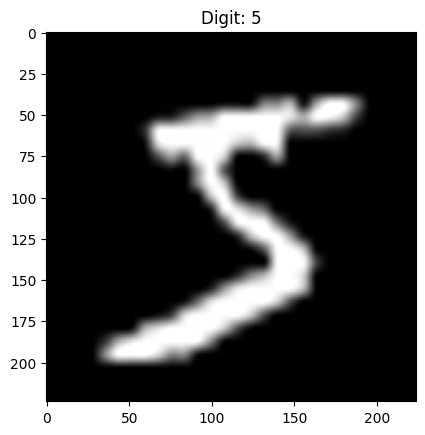

In [145]:
plt.figure()
plt.imshow(preprocess(
    Image.fromarray(np.concatenate(df.loc[0, "image"]).reshape(28, 28).astype(
        np.uint8),
                    mode="L")).numpy()[1],
           cmap="gray")
plt.title(f'Digit: {df.loc[0, "class"]}')
plt.show()

## Pets

The [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) contains 7,390 images divided across 37 classes of cat and dog breeds. Each class contains roughly 200 images.

```
@misc{pets,
  title={The Oxford-IIIT PET Dataset},
  author={Parkhi, Omkar M and Vedaldi, Andrea and Zisserman, Andrew and Jawahar, CV},
  howpublished={\url{https://www.robots.ox.ac.uk/~vgg/data/pets/}},
  year={2012},
}
```

### Download

In [146]:
if not (data_path / "pets/annotations/").exists():
    urllib.request.urlretrieve(
        "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz",
        str(data_path / "pets" / "annotations.tar.gz"))

    tar = tarfile.open(str(data_path / "pets" / "annotations.tar.gz"), "r:gz")
    tar.extractall(path=str(data_path / "pets"))
    tar.close()

In [148]:
if not (data_path / "pets/images/").exists():
    urllib.request.urlretrieve(
        "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz",
        str(data_path / "pets" / "images.tar.gz"))

    tar = tarfile.open(str(data_path / "pets" / "images.tar.gz", "r:gz"))
    tar.extractall(path=str(data_path / "pets"))
    tar.close()

In [149]:
df_annotations = pd.read_csv(
    data_path / "pets" / "annotations" / "list.txt",
    sep=" ",
    comment="#",
    names=["image", "class_id", "species_id", "breed_id"],
)

In [150]:
df_annotations["class"] = (
    df_annotations["image"].str.split("_").str[:-1].str.join("_"))

In [151]:
class_labels = df_annotations[["class", "class_id"]].drop_duplicates()

In [152]:
label_encoder = {
    row["class_id"]: row["class"] for _, row in class_labels.iterrows()
}

`class_id` is a global unique class id from 1 to 37, `species_id` is either 1 for cat or 2 for dog, `breed_id` is a class id that is only unique given the species.

### Embed

In [153]:
image_paths = list((data_path / "pets" / "images").glob("*.jpg"))

In [154]:
clip_vectors = []
n = 64
total = len(image_paths) // n + (len(image_paths) % n > 0)
for batch in tqdm(batched(image_paths, n), total=total):
    image_input = [preprocess(Image.open(x)) for x in batch]
    image_features = model.encode_image(
        torch.stack(image_input).to(device)).detach().numpy()
    clip_vectors.append(image_features)
clip_vectors = np.vstack(clip_vectors)

100%|██████████| 116/116 [01:55<00:00,  1.01it/s]


In [155]:
df = pd.DataFrame({
    "path": [str(x) for x in image_paths],
    "image": [x.stem for x in image_paths]
})

In [156]:
df["clip"] = clip_vectors.tolist()

In [157]:
df["clip_norm"] = (
    clip_vectors /
    np.linalg.norm(clip_vectors, axis=1, keepdims=True)).tolist()

In [158]:
df["class"] = df["image"].str.split("_").str[:-1].str.join("_")

In [159]:
df["species"] = df["class"].str[0].str.isupper().map({
    True: "cat",
    False: "dog",
})

In [160]:
df["image_n"] = df["image"].str.split("_").str[-1].astype(int)

In [161]:
test_set = pd.read_csv(
    data_path / "pets" / "annotations" / "test.txt",
    sep=" ",
    comment="#",
    names=["image", "class_id", "species_id", "breed_id"],
)["image"]

In [162]:
train_set = pd.read_csv(
    data_path / "pets" / "annotations" / "trainval.txt",
    sep=" ",
    comment="#",
    names=["image", "class_id", "species_id", "breed_id"],
)["image"]

In [163]:
df["split"] = pd.NA
df.loc[df["image"].isin(test_set), "split"] = "test"
df.loc[df["image"].isin(train_set), "split"] = "train"

In [164]:
df = df.sort_values(["class", "image_n"]).reset_index(drop=True)

In [165]:
df.to_parquet(data_path / "pets" / "pets.parquet")

### Incomplete Annotations

Some images were not listed in the given annotations. The given annotations were discarded and complete ones built instead.

In [166]:
print(f"Number of annotations: {df_annotations.shape[0]}")
print(f"Number of images: {clip_vectors.shape[0]}")

Number of annotations: 7349
Number of images: 7390


In [167]:
n_test = (data_path / "pets/annotations/test.txt").read_text().count("\n")
n_train = (data_path / "pets/annotations/trainval.txt").read_text().count("\n")
print(n_test, n_train, n_test + n_train)

3669 3680 7349


In [168]:
df.loc[~df["image"].isin(df_annotations["image"]), "image"].shape[0]

41

In [169]:
df["split"].isna().sum()

41

In [170]:
df_annotations.loc[~df_annotations["image"].isin(df["image"]), "image"]

Series([], Name: image, dtype: object)

In [171]:
df_annotations.groupby("class").size().sort_values()

class
Bombay                        184
staffordshire_bull_terrier    189
Egyptian_Mau                  190
newfoundland                  196
english_cocker_spaniel        196
Abyssinian                    198
boxer                         199
keeshond                      199
scottish_terrier              199
Siamese                       199
Persian                       200
Ragdoll                       200
Birman                        200
British_Shorthair             200
Russian_Blue                  200
Sphynx                        200
beagle                        200
basset_hound                  200
american_pit_bull_terrier     200
american_bulldog              200
german_shorthaired            200
great_pyrenees                200
chihuahua                     200
english_setter                200
japanese_chin                 200
havanese                      200
leonberger                    200
miniature_pinscher            200
pomeranian                    200
pug     

In [172]:
df.groupby("class").size().sort_values()

class
staffordshire_bull_terrier    191
scottish_terrier              199
Abyssinian                    200
Bengal                        200
British_Shorthair             200
Egyptian_Mau                  200
Birman                        200
Bombay                        200
Ragdoll                       200
Russian_Blue                  200
Siamese                       200
Sphynx                        200
american_bulldog              200
american_pit_bull_terrier     200
Maine_Coon                    200
Persian                       200
boxer                         200
chihuahua                     200
english_cocker_spaniel        200
english_setter                200
german_shorthaired            200
great_pyrenees                200
havanese                      200
japanese_chin                 200
keeshond                      200
leonberger                    200
miniature_pinscher            200
newfoundland                  200
pomeranian                    200
pug     